In [88]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import re
import os
from datetime import datetime

In [89]:
!rm -r eda
!rm eda.zip
print("The 'eda' folder and 'eda.zip' file have been deleted.")

The 'eda' folder and 'eda.zip' file have been deleted.


In [90]:
config = {
    "batch_size": 32,
    "epochs": 130,
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,
    "optimizer": "Adam",
    "loss_function": "CrossEntropyLoss",
    "test_selection": "2nd_from_top_and_bottom",  # "random" or "2nd_from_top_and_bottom"
    # "test_selection": "random",  # "random" or "2nd_from_top_and_bottom"
    "ignore_e8_e9": True,
    "remove_small_errors": True,
    "zooms": ['z2'], # ['z1'] or ['z2'] or ['z1', 'z2']
    "model_": "MultiOutputClassifier",
    "model": "TwoStageClassifier",
    "parameter_loss_weight": 1  # Weight for parameter loss in combined loss
}

### Load Data and Initial Processing

In [91]:
# Load the CSV data
print("Loading CSV data...")
df = pd.read_excel("/content/‏‏Lab_Sensitivity_results 680204 (15)_ver C_twoZooms_20250908 - copy.xlsx", sheet_name='Sheet1')

# Remove "Nominal" rows
df = df[df["name"] != "Nominal"]
print(f"Dataset shape after removing Nominal: {df.shape}")

Loading CSV data...
Dataset shape after removing Nominal: (1260, 43)


In [92]:
# Split the name into error_name and parameter_name
def split_parameter_name(name):
    """Split parameter name into error type and element"""
    # Find the last part that matches E followed by number or G followed by number
    match = re.search(r'(E\d+|G\d+)$', name)
    if match:
        parameter_name = match.group(1)
        error_name = name.replace(parameter_name, '').strip()
        return error_name, parameter_name
    else:
        # If no match, return the whole name as error_name and empty parameter_name
        return name, ""

# Apply the split
df[['error_name', 'parameter_name']] = df['name'].apply(
    lambda x: pd.Series(split_parameter_name(x))
)

### Filter Data based on Configuration

In [93]:
# Find the rows where parameter_name is neither "E8" nor "E9"
# The correct condition is (df["parameter_name"] != "E8") AND (df["parameter_name"] != "E9")
# Note: This assumes the 'parameter_name' column exists in the DataFrame.
# If not, rerun the data loading and splitting steps (cells z_-4mJcD-YWA and d46bc68a).
rows_not_e8_e9 = df[(df["parameter_name"] != "E8") & (df["parameter_name"] != "E9")]

# Display the index of these rows (which are the row numbers)
print("Row numbers where parameter_name is neither 'E8' nor 'E9':")
print(rows_not_e8_e9.index.tolist())

print(f"\nNumber of rows where parameter_name is neither 'E8' nor 'E9': {len(rows_not_e8_e9)}")

Row numbers where parameter_name is neither 'E8' nor 'E9':
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 2

In [94]:
# Find the rows where parameter_name is either "E8" or "E9"
rows_e8_or_e9 = df[(df["parameter_name"] == "E8") | (df["parameter_name"] == "E9")]

# Display the index of these rows (which are the row numbers)
print("Row numbers where parameter_name is either 'E8' or 'E9':")
print(rows_e8_or_e9.index.tolist())

print(f"\nNumber of rows where parameter_name is either 'E8' or 'E9': {len(rows_e8_or_e9)}")

Row numbers where parameter_name is either 'E8' or 'E9':
[]

Number of rows where parameter_name is either 'E8' or 'E9': 0


In [95]:
# keep only the rows with the specified zooms
df = df[df["efl"].isin(config["zooms"])]
'''
if config["ignore_e8_e9"]:
    df = df[df["parameter_name"] != "E8"]
    df = df[df["parameter_name"] != "E9"]

if config["remove_small_errors"]:
    # remove the 2 rows with smallest absolute error from each error_name and parameter_name
    df = df.groupby(['error_name', 'parameter_name']).apply(lambda x: x.sort_values(by='error', key=lambda x: abs(x)).iloc[2:])
    df = df.reset_index(drop=True)
'''

print("\nUnique error names:")
print(df['error_name'].unique())
print(f"\nUnique parameter names:")
print(df['parameter_name'].unique())


Unique error names:
['Radius s1' 'Radius s2' 'Irr s1' 'Irr s2' 'Thickness' 'ETV' 'Z Position'
 'Decenter' 'Tilt']

Unique parameter names:
['E1' 'E2' 'E3' 'E4' 'E5' 'E6' 'E7']


In [96]:
display(df.head(10))

,name,error,freq,efl,c2,c3,c4,c5,c6,c7,...,c33,c34,c35,c36,c37,MTF,MTF poly - On axis - S,MTF poly - On axis - T,error_name,parameter_name
3,Radius s1 E1,-0.0100,25,z2,-7.831192e-14,-7.895894e-16,-0.009331,3.891984e-14,-2.691255e-13,-5.131977e-14,...,1.354420e-13,-1.806633e-13,-5.364807e-14,-0.000084,0.000004,0.425583,0.470678,0.470678,Radius s1,E1
5,Radius s1 E1,-0.0075,25,z2,-2.177818e-13,-2.390434e-13,-0.009277,5.243379e-14,-2.550493e-13,-9.483065e-14,...,-1.762823e-13,-4.886340e-14,1.080607e-13,-0.000084,0.000004,0.425577,0.470443,0.470443,Radius s1,E1
7,Radius s1 E1,-0.0050,25,z2,-4.165981e-13,-4.296608e-13,-0.009223,3.385654e-14,-8.975590e-14,-1.774126e-13,...,-3.599705e-13,-9.738805e-14,-7.610032e-14,-0.000084,0.000004,0.425571,0.470043,0.470043,Radius s1,E1
9,Radius s1 E1,-0.0025,25,z2,3.653297e-13,3.559784e-13,-0.009169,-3.282457e-14,3.130311e-15,3.854093e-13,...,3.459461e-13,1.245720e-13,7.670740e-14,-0.000085,0.000004,0.425565,0.469995,0.469995,Radius s1,E1
11,Radius s1 E1,-0.0010,25,z2,-1.365693e-13,-7.950521e-14,-0.009136,-7.328153e-14,-1.429621e-14,-2.876918e-13,...,1.172750e-13,4.865138e-13,4.549173e-13,-0.000085,0.000004,0.425561,0.469807,0.469807,Radius s1,E1
13,Radius s1 E1,-0.0005,25,z2,-1.407450e-13,-1.261754e-13,-0.009125,1.129584e-14,-2.844456e-13,1.360686e-14,...,-6.201105e-13,-2.407983e-14,1.665598e-14,-0.000085,0.000004,0.425560,0.469805,0.469805,Radius s1,E1
15,Radius s1 E1,0.0005,25,z2,8.619145e-14,3.421729e-14,-0.009104,-2.166371e-13,-5.127902e-14,3.549500e-13,...,-1.866329e-14,-7.279432e-14,-5.018852e-14,-0.000085,0.000004,0.425557,0.469693,0.469693,Radius s1,E1
17,Radius s1 E1,0.0010,25,z2,4.082514e-14,-3.861021e-14,-0.009093,7.269387e-14,-5.353852e-14,5.225629e-14,...,-4.030833e-13,-6.638440e-13,-6.428992e-13,-0.000085,0.000004,0.425556,0.469692,0.469692,Radius s1,E1
19,Radius s1 E1,0.0025,25,z2,1.792913e-13,-1.060957e-14,-0.009060,2.145101e-13,3.707742e-13,6.552571e-14,...,-5.330995e-13,9.503880e-14,-2.685768e-13,-0.000086,0.000004,0.425553,0.469687,0.469687,Radius s1,E1
21,Radius s1 E1,0.0050,25,z2,1.612786e-13,1.993359e-13,-0.009006,4.214802e-14,1.622890e-13,-1.161604e-13,...,-2.309826e-13,-4.262072e-13,-4.614821e-13,-0.000086,0.000004,0.425547,0.469572,0.469572,Radius s1,E1


### Encode Categorical Variables

In [97]:
# Encode the categorical variables
le_error = LabelEncoder()
le_parameter = LabelEncoder()

df['error_name_encoded'] = le_error.fit_transform(df['error_name'])
df['parameter_name_encoded'] = le_parameter.fit_transform(df['parameter_name'])

print(f"\nNumber of error types: {len(le_error.classes_)}")
print(f"Number of parameter types: {len(le_parameter.classes_)}")


Number of error types: 9
Number of parameter types: 7


In [98]:
le_error.classes_

array(['Decenter', 'ETV', 'Irr s1', 'Irr s2', 'Radius s1', 'Radius s2',
       'Thickness', 'Tilt', 'Z Position'], dtype=object)

### Prepare Features and Create Train/Test Split

In [99]:
# Prepare features (excluding the target columns)
feature_columns1 = [f'c{i}' for i in range(2, 38)]
feature_columns2 = ['MTF poly - On axis - S'] + ['MTF poly - On axis - T'] + ['MTF']


# Create train/test split based on error_name + parameter_name groups
train_data = []
test_data = []

print("\nCreating train/test split...")
# Ensure 'error_name' and 'parameter_name' columns are present in df.
# If not, rerun the data loading and splitting steps (cells above).
for error_name in df['error_name'].unique():
    for parameter_name in df['parameter_name'].unique():
        # Get data for this specific error_name + parameter_name combination
        group_data = df[(df['error_name'] == error_name) &
                       (df['parameter_name'] == parameter_name)]

        if len(group_data) < 4:
            print(f"Skipping {error_name} {parameter_name}: only {len(group_data)} samples")
            continue

        # Sort by error value
        group_data_sorted = group_data.sort_values('error')

        if config["test_selection"] == "random":
            test_indices = np.random.choice(len(group_data_sorted), size=2, replace=False)
        elif config["test_selection"] == "2nd_from_top_and_bottom":
            test_indices = [1, len(group_data_sorted) - 2]  # Second from top and second from bottom
        else:
            raise ValueError(f"Invalid test selection: {config['test_selection']}")

        test_rows = group_data_sorted.iloc[test_indices]
        train_rows = group_data_sorted.drop(group_data_sorted.index[test_indices])

        test_data.extend(test_rows.to_dict('records'))
        train_data.extend(train_rows.to_dict('records'))

# Convert back to DataFrames
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

print(f"Training set size: {len(df_train)}")
print(f"Test set size: {len(df_test)}")

# Prepare features and targets
X1_train = df_train[feature_columns1].values
X1_test = df_test[feature_columns1].values
X2_train = df_train[feature_columns2].values
X2_test = df_test[feature_columns2].values

y_error_train = df_train['error_name_encoded'].values
y_error_test = df_test['error_name_encoded'].values

y_parameter_train = df_train['parameter_name_encoded'].values
y_parameter_test = df_test['parameter_name_encoded'].values



Creating train/test split...
Training set size: 504
Test set size: 126


### Scale Features

In [100]:
# Scale features
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

print(f"\nFeature shapes:")
print(f"X1_train: {X1_train_scaled.shape}")
print(f"X1_test: {X1_test_scaled.shape}")
print(f"X2_train: {X2_train_scaled.shape}")
print(f"X2_test: {X2_test_scaled.shape}")
print(f"y_error_train: {y_error_train.shape}")
print(f"y_parameter_train: {y_parameter_train.shape}")


Feature shapes:
X1_train: (504, 36)
X1_test: (126, 36)
X2_train: (504, 3)
X2_test: (126, 3)
y_error_train: (504,)
y_parameter_train: (504,)


### Create PyTorch Datasets and DataLoaders

In [101]:
# Create PyTorch Dataset
class OpticalDataset(Dataset):
    def __init__(self, X1, X2, y_error, y_parameter):
        self.X1 = torch.tensor(X1, dtype=torch.float32)
        self.X2 = torch.tensor(X2, dtype=torch.float32)
        self.y_error = torch.tensor(y_error, dtype=torch.long)
        self.y_parameter = torch.tensor(y_parameter, dtype=torch.long)

    def __len__(self):
        return len(self.X1)

    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y_error[idx], self.y_parameter[idx]

# Create datasets
train_dataset = OpticalDataset(X1_train_scaled, X2_train_scaled, y_error_train, y_parameter_train)
test_dataset = OpticalDataset(X1_test_scaled, X2_test_scaled, y_error_test, y_parameter_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

print(f"\nData loaders created:")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

# Print class information for the neural network
print(f"\nClass information for neural network:")
print(f"Input dimension X1: {X1_train_scaled.shape[1]}")
print(f"Input dimension X2: {X2_train_scaled.shape[1]}")
print(f"Number of error types: {len(le_error.classes_)}")
print(f"Number of parameter types: {len(le_parameter.classes_)}")

print(f"\nError type classes:")
for i, class_name in enumerate(le_error.classes_):
    print(f"  {i}: {class_name}")

print(f"\nParameter type classes:")
for i, class_name in enumerate(le_parameter.classes_):
    print(f"  {i}: {class_name}")


Data loaders created:
Training batches: 16
Test batches: 4

Class information for neural network:
Input dimension X1: 36
Input dimension X2: 3
Number of error types: 9
Number of parameter types: 7

Error type classes:
  0: Decenter
  1: ETV
  2: Irr s1
  3: Irr s2
  4: Radius s1
  5: Radius s2
  6: Thickness
  7: Tilt
  8: Z Position

Parameter type classes:
  0: E1
  1: E2
  2: E3
  3: E4
  4: E5
  5: E6
  6: E7


### Save Encoders, Scaler, and Configuration

In [102]:
# Create timestamped directory for results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = f"eda/plots/neural_network_results_{timestamp}"
os.makedirs(results_dir, exist_ok=True)
print(f"\nResults will be saved to: {results_dir}")

# Save the encoders and scaler for later use
import pickle
with open(f'{results_dir}/encoders_and_scaler.pkl', 'wb') as f:
    pickle.dump({
        'le_error': le_error,
        'le_parameter': le_parameter,
        'scaler': scaler,
        'feature_columns': feature_columns1 + feature_columns2
    }, f)

# Save the config for reproducibility as a json file
with open(f'{results_dir}/config.json', 'w') as f:
    json.dump(config, f)

print(f"Encoders and scaler saved to '{results_dir}/encoders_and_scaler.pkl'")
print(f"Configuration saved to '{results_dir}/config.json'")


Results will be saved to: eda/plots/neural_network_results_20251015_012814
Encoders and scaler saved to 'eda/plots/neural_network_results_20251015_012814/encoders_and_scaler.pkl'
Configuration saved to 'eda/plots/neural_network_results_20251015_012814/config.json'


### Test DataLoaders

In [103]:
# Test the data loaders
print(f"\nTesting data loaders...")
for batch_idx, (X1_batch, X2_batch, y_error_batch, y_parameter_batch) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"  X1 shape: {X1_batch.shape}")
    print(f"  X2 shape: {X2_batch.shape}")
    print(f"  y_error shape: {y_error_batch.shape}")
    print(f"  y_parameter shape: {y_parameter_batch.shape}")
    print(f"  y_error range: {y_error_batch.min().item()} to {y_error_batch.max().item()}")
    print(f"  y_parameter range: {y_parameter_batch.min().item()} to {y_parameter_batch.max().item()}")
    break

print(f"\nData preparation complete! Ready for neural network training.")


Testing data loaders...
Batch 1:
  X1 shape: torch.Size([32, 36])
  X2 shape: torch.Size([32, 3])
  y_error shape: torch.Size([32])
  y_parameter shape: torch.Size([32])
  y_error range: 0 to 8
  y_parameter range: 0 to 6

Data preparation complete! Ready for neural network training.


### Initialize Model, Optimizer, and Loss Function

In [104]:
# Import the neural network model
import sys
sys.path.append('.')
# from eda.nn_model import MultiOutputClassifier # Original import
# from eda.nn_model_two_stages import TwoStageClassifier # Original import
'''
from nn_model import MultiOutputClassifier
'''
from nn_model_two_stages_V2 import TwoStageClassifier


# Update model configuration based on actual data
INPUT_DIM_X1 = X1_train_scaled.shape[1]
INPUT_DIM_X2 = X2_train_scaled.shape[1]
NUM_ERROR_TYPES = len(le_error.classes_)
NUM_ERROR_ELEMENTS = len(le_parameter.classes_)

print(f"\n" + "="*50)
print("NEURAL NETWORK TRAINING")
print("="*50)
print(f"Input dimension X1: {INPUT_DIM_X1}")
print(f"Input dimension X2: {INPUT_DIM_X2}")
print(f"Number of error types: {NUM_ERROR_TYPES}")
print(f"Number of error elements: {NUM_ERROR_ELEMENTS}")


NEURAL NETWORK TRAINING
Input dimension X1: 36
Input dimension X2: 3
Number of error types: 9
Number of error elements: 7


In [105]:
# Initialize model, optimizer, and loss function
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

if config["model"] == "MultiOutputClassifier":
    '''
    model = MultiOutputClassifier(INPUT_DIM, NUM_ERROR_TYPES, NUM_ERROR_ELEMENTS)
    '''
    raise ValueError("MultiOutputClassifier is not compatible with two inputs")
elif config["model"] == "TwoStageClassifier":
    model = TwoStageClassifier(INPUT_DIM_X1, INPUT_DIM_X2, NUM_ERROR_TYPES, NUM_ERROR_ELEMENTS)
else:
    raise ValueError(f"Unknown model type: {config['model']}")


optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

criterion = nn.CrossEntropyLoss()

print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

Model initialized with 2436 parameters


### Training Loop

In [106]:
# Training loop
print(f"\nStarting training for {config['epochs']} epochs...")
train_losses = []
val_losses = []
train_acc_error = []
train_acc_parameter = []
val_acc_error = []
val_acc_parameter = []

for epoch in range(config["epochs"]):
    # Training phase
    model.train()
    total_loss = 0
    correct_error = 0
    correct_parameter = 0
    total_samples = 0

    '''
    for X_batch, y_error_batch, y_parameter_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        out_error, out_parameter = model(X_batch)

        # Calculate losses
        loss_error = criterion(out_error, y_error_batch)
        loss_parameter = criterion(out_parameter, y_parameter_batch)
        loss = loss_error + config["parameter_loss_weight"] * loss_parameter

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        pred_error = out_error.argmax(dim=1)
        pred_parameter = out_parameter.argmax(dim=1)
        correct_error += (pred_error == y_error_batch).sum().item()
        correct_parameter += (pred_parameter == y_parameter_batch).sum().item()
        total_samples += y_error_batch.size(0)
    '''
    for X1_batch, X2_batch, y_error_batch, y_parameter_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        out_error, out_parameter = model(X1_batch, X2_batch) # error_type_logits, error_element_logits

        # Calculate losses
        loss_error = criterion(out_error, y_error_batch)
        loss_parameter = criterion(out_parameter, y_parameter_batch)
        loss = loss_error + config["parameter_loss_weight"] * loss_parameter

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        pred_error = out_error.argmax(dim=1)
        pred_parameter = out_parameter.argmax(dim=1)
        correct_error += (pred_error == y_error_batch).sum().item()
        correct_parameter += (pred_parameter == y_parameter_batch).sum().item()
        total_samples += y_error_batch.size(0)


    # Calculate training metrics
    avg_loss = total_loss / len(train_loader)
    acc_error = correct_error / total_samples
    acc_parameter = correct_parameter / total_samples

    train_losses.append(avg_loss)
    train_acc_error.append(acc_error)
    train_acc_parameter.append(acc_parameter)

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct_error = 0
    val_correct_parameter = 0
    val_total_samples = 0

    with torch.no_grad():
        '''
        for X_batch, y_error_batch, y_parameter_batch in test_loader:
            out_error, out_parameter = model(X_batch)

            loss_error = criterion(out_error, y_error_batch)
            loss_parameter = criterion(out_parameter, y_parameter_batch)
            loss = loss_error + config["parameter_loss_weight"] * loss_parameter

            val_loss += loss.item()
            pred_error = out_error.argmax(dim=1)
            pred_parameter = out_parameter.argmax(dim=1)
            val_correct_error += (pred_error == y_error_batch).sum().item()
            val_correct_parameter += (pred_parameter == y_parameter_batch).sum().item()
            val_total_samples += y_error_batch.size(0)
        '''
        for X1_batch, X2_batch, y_error_batch, y_parameter_batch in test_loader:
            out_error, out_parameter = model(X1_batch, X2_batch)

            loss_error = criterion(out_error, y_error_batch)
            loss_parameter = criterion(out_parameter, y_parameter_batch)
            loss = loss_error + config["parameter_loss_weight"] * loss_parameter

            val_loss += loss.item()
            pred_error = out_error.argmax(dim=1)
            pred_parameter = out_parameter.argmax(dim=1)
            val_correct_error += (pred_error == y_error_batch).sum().item()
            val_correct_parameter += (pred_parameter == y_parameter_batch).sum().item()
            val_total_samples += y_error_batch.size(0)


    avg_val_loss = val_loss / len(test_loader)
    val_acc_error_epoch = val_correct_error / val_total_samples
    val_acc_parameter_epoch = val_correct_parameter / val_total_samples

    val_losses.append(avg_val_loss)
    val_acc_error.append(val_acc_error_epoch)
    val_acc_parameter.append(val_acc_parameter_epoch)

    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:2d}/{config['epochs']} - "
              f"Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f} - "
              f"Train Acc (Error/Param): {acc_error:.3f}/{acc_parameter:.3f} - "
              f"Val Acc (Error/Param): {val_acc_error_epoch:.3f}/{val_acc_parameter_epoch:.3f}")


Starting training for 130 epochs...
Epoch  5/130 - Train Loss: 4.0785, Val Loss: 4.0610 - Train Acc (Error/Param): 0.252/0.147 - Val Acc (Error/Param): 0.254/0.167
Epoch 10/130 - Train Loss: 3.8360, Val Loss: 3.7247 - Train Acc (Error/Param): 0.341/0.161 - Val Acc (Error/Param): 0.341/0.143
Epoch 15/130 - Train Loss: 3.5160, Val Loss: 3.3410 - Train Acc (Error/Param): 0.417/0.272 - Val Acc (Error/Param): 0.421/0.262
Epoch 20/130 - Train Loss: 3.2464, Val Loss: 3.0607 - Train Acc (Error/Param): 0.458/0.313 - Val Acc (Error/Param): 0.460/0.357
Epoch 25/130 - Train Loss: 3.0376, Val Loss: 2.8633 - Train Acc (Error/Param): 0.468/0.335 - Val Acc (Error/Param): 0.460/0.381
Epoch 30/130 - Train Loss: 2.8779, Val Loss: 2.7289 - Train Acc (Error/Param): 0.500/0.349 - Val Acc (Error/Param): 0.492/0.381
Epoch 35/130 - Train Loss: 2.7477, Val Loss: 2.6280 - Train Acc (Error/Param): 0.526/0.367 - Val Acc (Error/Param): 0.524/0.389
Epoch 40/130 - Train Loss: 2.6509, Val Loss: 2.5389 - Train Acc (Er

### Final Evaluation and Reporting

In [107]:
# Final evaluation
print(f"\n" + "="*50)
print("FINAL EVALUATION")
print("="*50)

model.eval()
all_pred_error = []
all_pred_parameter = []
all_true_error = []
all_true_parameter = []

with torch.no_grad():
    '''
    for X_batch, y_error_batch, y_parameter_batch in test_loader:
        out_error, out_parameter = model(X_batch)
        pred_error = out_error.argmax(dim=1)
        pred_parameter = out_parameter.argmax(dim=1)

        all_pred_error.extend(pred_error.cpu().numpy())
        all_pred_parameter.extend(pred_parameter.cpu().numpy())
        all_true_error.extend(y_error_batch.cpu().numpy())
        all_true_parameter.extend(y_parameter_batch.cpu().numpy())
    '''
    for X1_batch, X2_batch, y_error_batch, y_parameter_batch in test_loader:
        out_error, out_parameter = model(X1_batch, X2_batch)
        pred_error = out_error.argmax(dim=1)
        pred_parameter = out_parameter.argmax(dim=1)

        all_pred_error.extend(pred_error.cpu().numpy())
        all_pred_parameter.extend(pred_parameter.cpu().numpy())
        all_true_error.extend(y_error_batch.cpu().numpy())
        all_true_parameter.extend(y_parameter_batch.cpu().numpy())

# Calculate final metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

final_error_acc = accuracy_score(all_true_error, all_pred_error)
final_parameter_acc = accuracy_score(all_true_parameter, all_pred_parameter)

print(f"Final Test Accuracy - Error Types: {final_error_acc:.4f}")
print(f"Final Test Accuracy - Parameter Types: {final_parameter_acc:.4f}")

print(f"\nError Type Classification Report:")
print(classification_report(all_true_error, all_pred_error,
                          target_names=le_error.classes_))

print(f"\nParameter Type Classification Report:")
print(classification_report(all_true_parameter, all_pred_parameter,
                          target_names=le_parameter.classes_))


FINAL EVALUATION
Final Test Accuracy - Error Types: 0.5952
Final Test Accuracy - Parameter Types: 0.5635

Error Type Classification Report:
              precision    recall  f1-score   support

    Decenter       0.50      0.64      0.56        14
         ETV       0.78      0.50      0.61        14
      Irr s1       0.93      0.93      0.93        14
      Irr s2       0.92      0.86      0.89        14
   Radius s1       0.29      0.43      0.34        14
   Radius s2       0.50      0.29      0.36        14
   Thickness       0.47      0.57      0.52        14
        Tilt       0.67      0.57      0.62        14
  Z Position       0.57      0.57      0.57        14

    accuracy                           0.60       126
   macro avg       0.62      0.60      0.60       126
weighted avg       0.62      0.60      0.60       126


Parameter Type Classification Report:
              precision    recall  f1-score   support

          E1       0.75      0.67      0.71        18
      

### Plot Training Curves

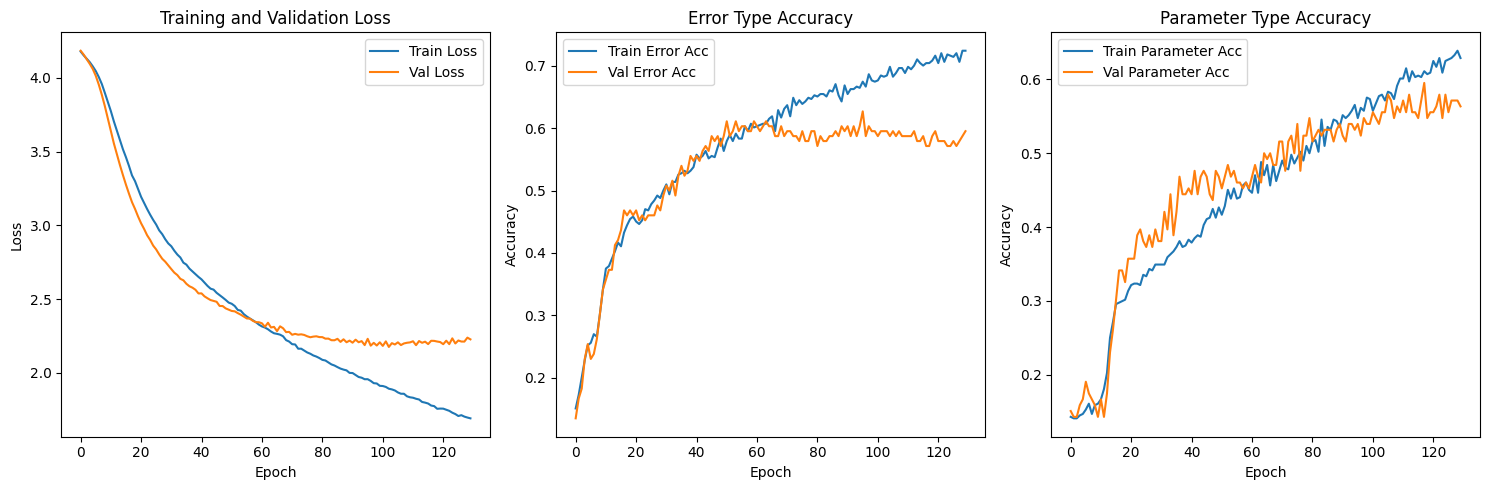

In [108]:
# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_acc_error, label='Train Error Acc')
plt.plot(val_acc_error, label='Val Error Acc')
plt.title('Error Type Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_acc_parameter, label='Train Parameter Acc')
plt.plot(val_acc_parameter, label='Val Parameter Acc')
plt.title('Parameter Type Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(f'{results_dir}/neural_network_training_curves.png', dpi=300, bbox_inches='tight')

### Save Trained Model

In [109]:
# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'input_dim_X1': INPUT_DIM_X1,
    'input_dim_X2': INPUT_DIM_X2,
    '''
    'input_dim': INPUT_DIM,
    '''
    'num_error_types': NUM_ERROR_TYPES,
    'num_error_elements': NUM_ERROR_ELEMENTS,
    'final_error_acc': final_error_acc,
    'final_parameter_acc': final_parameter_acc
}, f'{results_dir}/optical_classifier.pth')

print(f"\nModel saved to '{results_dir}/optical_classifier.pth'")
print(f"Training complete!")


Model saved to 'eda/plots/neural_network_results_20251015_012814/optical_classifier.pth'
Training complete!


### Create and Save Summary Report

In [110]:
# Create summary report
summary_report = f"""
NEURAL NETWORK TRAINING SUMMARY
================================
Timestamp: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
Results Directory: {results_dir}

DATA PREPARATION
----------------
Dataset shape after removing Nominal: {len(df)} samples
Training set size: {len(df_train)} samples
Test set size: {len(df_test)} samples
Number of error types: {NUM_ERROR_TYPES}
Number of parameter types: {NUM_ERROR_ELEMENTS}
Input features X1: {feature_columns1}
Input features X2: {feature_columns2}


MODEL ARCHITECTURE
------------------
Input dimension X1: {INPUT_DIM_X1}
Input dimension X2: {INPUT_DIM_X2}
Hidden layers: 128 -> 64 (with dropout 0.3)
Error type output: {NUM_ERROR_TYPES} classes
Parameter type output: {NUM_ERROR_ELEMENTS} classes
Total parameters: {sum(p.numel() for p in model.parameters())}

TRAINING CONFIGURATION
---------------------
Epochs: {config['epochs']}
Learning rate: {config['learning_rate']}
Weight decay: {config['weight_decay']}
Optimizer: {config['optimizer']}
Loss function: {config['loss_function']}
Batch size: {config['batch_size']}
Parameter loss weight: {config['parameter_loss_weight']}
Model: {config['model']}
Test selection: {config['test_selection']}
Ignore E8/E9: {config['ignore_e8_e9']}
Remove small errors: {config['remove_small_errors']}
Zooms: {config['zooms']}

FINAL RESULTS
-------------
Error Type Classification Accuracy: {final_error_acc:.4f} ({final_error_acc*100:.2f}%)
Parameter Type Classification Accuracy: {final_parameter_acc:.4f} ({final_parameter_acc*100:.2f}%)

ERROR TYPE PERFORMANCE
---------------------
"""
# Append classification report for error types
from sklearn.metrics import classification_report
error_report = classification_report(all_true_error, all_pred_error, target_names=le_error.classes_)
summary_report += error_report

summary_report += f"""
PARAMETER TYPE PERFORMANCE
-------------------------
"""
# Append classification report for parameter types
parameter_report = classification_report(all_true_parameter, all_pred_parameter, target_names=le_parameter.classes_)
summary_report += parameter_report


summary_report += f"""
FILES SAVED
-----------
- Model checkpoint: {results_dir}/optical_classifier.pth
- Encoders and scaler: {results_dir}/encoders_and_scaler.pkl
- Configuration: {results_dir}/config.json
- Training curves: {results_dir}/neural_network_training_curves.png
- Error confusion matrix: {results_dir}/neural_network_error_confusion_matrix.png
- Parameter confusion matrix: {results_dir}/neural_network_parameter_confusion_matrix.png
- Sorted parameter confusion matrix: {results_dir}/neural_network_parameter_confusion_matrix_sorted.png
- Summary report: {results_dir}/training_summary.txt

NOTES
-----
- Error type classification performs better than parameter type classification
- Model shows learning progression over {config['epochs']} epochs
- Weight decay helps prevent overfitting
- Parameter loss weight: {config['parameter_loss_weight']}
- Test selection strategy: {config['test_selection']}
"""

# Save summary report
with open(f'{results_dir}/training_summary.txt', 'w') as f:
    f.write(summary_report)

print(f"\nSummary report saved to '{results_dir}/training_summary.txt'")
print(summary_report)


Summary report saved to 'eda/plots/neural_network_results_20251015_012814/training_summary.txt'

NEURAL NETWORK TRAINING SUMMARY
Timestamp: 2025-10-15 01:28:22
Results Directory: eda/plots/neural_network_results_20251015_012814

DATA PREPARATION
----------------
Dataset shape after removing Nominal: 630 samples
Training set size: 504 samples
Test set size: 126 samples
Number of error types: 9
Number of parameter types: 7
Input features X1: ['c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28', 'c29', 'c30', 'c31', 'c32', 'c33', 'c34', 'c35', 'c36', 'c37']
Input features X2: ['MTF poly - On axis - S', 'MTF poly - On axis - T', 'MTF']


MODEL ARCHITECTURE
------------------
Input dimension X1: 36
Input dimension X2: 3
Hidden layers: 128 -> 64 (with dropout 0.3)
Error type output: 9 classes
Parameter type output: 7 classes
Total parameters: 2436

TRAINING CONFIGU

### Plot Confusion Matrices


CONFUSION MATRICES

NEURAL NETWORK PARAMETER CONFUSION MATRIX - SORTED BY SUFFIX

Confusion matrices saved:
- Error types: eda/plots/neural_network_results_20251015_012814/neural_network_error_confusion_matrix.png
- Parameter types: eda/plots/neural_network_results_20251015_012814/neural_network_parameter_confusion_matrix.png
- Parameter types (sorted): eda/plots/neural_network_results_20251015_012814/neural_network_parameter_confusion_matrix_sorted.png

All results saved to: eda/plots/neural_network_results_20251015_012814
Summary report: eda/plots/neural_network_results_20251015_012814/training_summary.txt


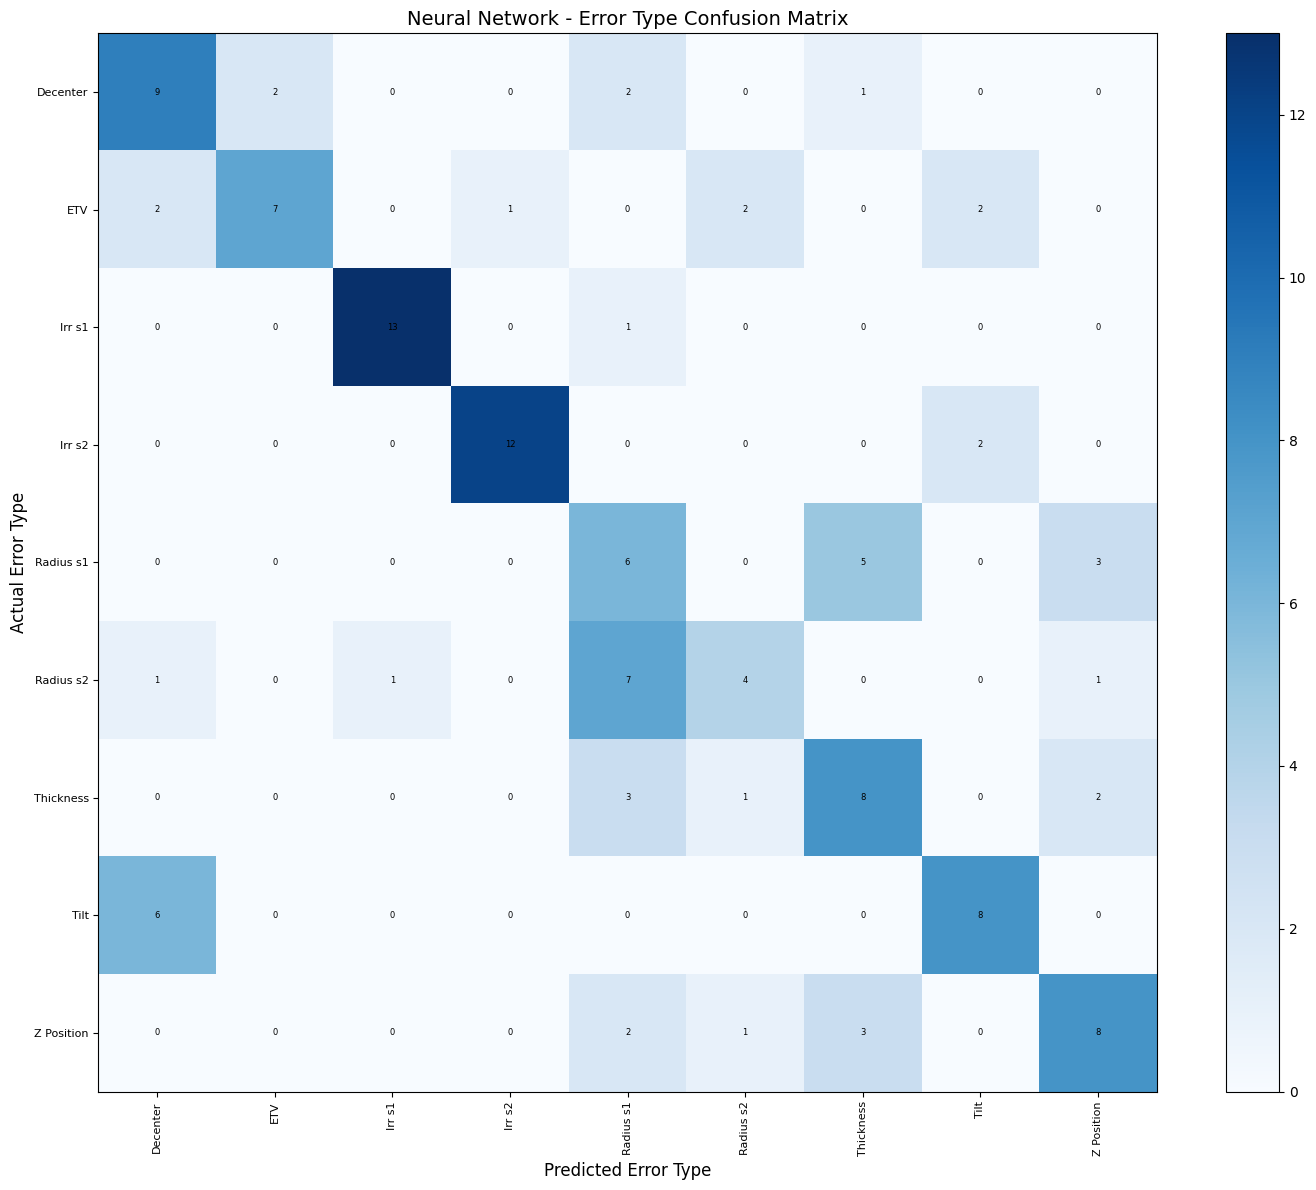

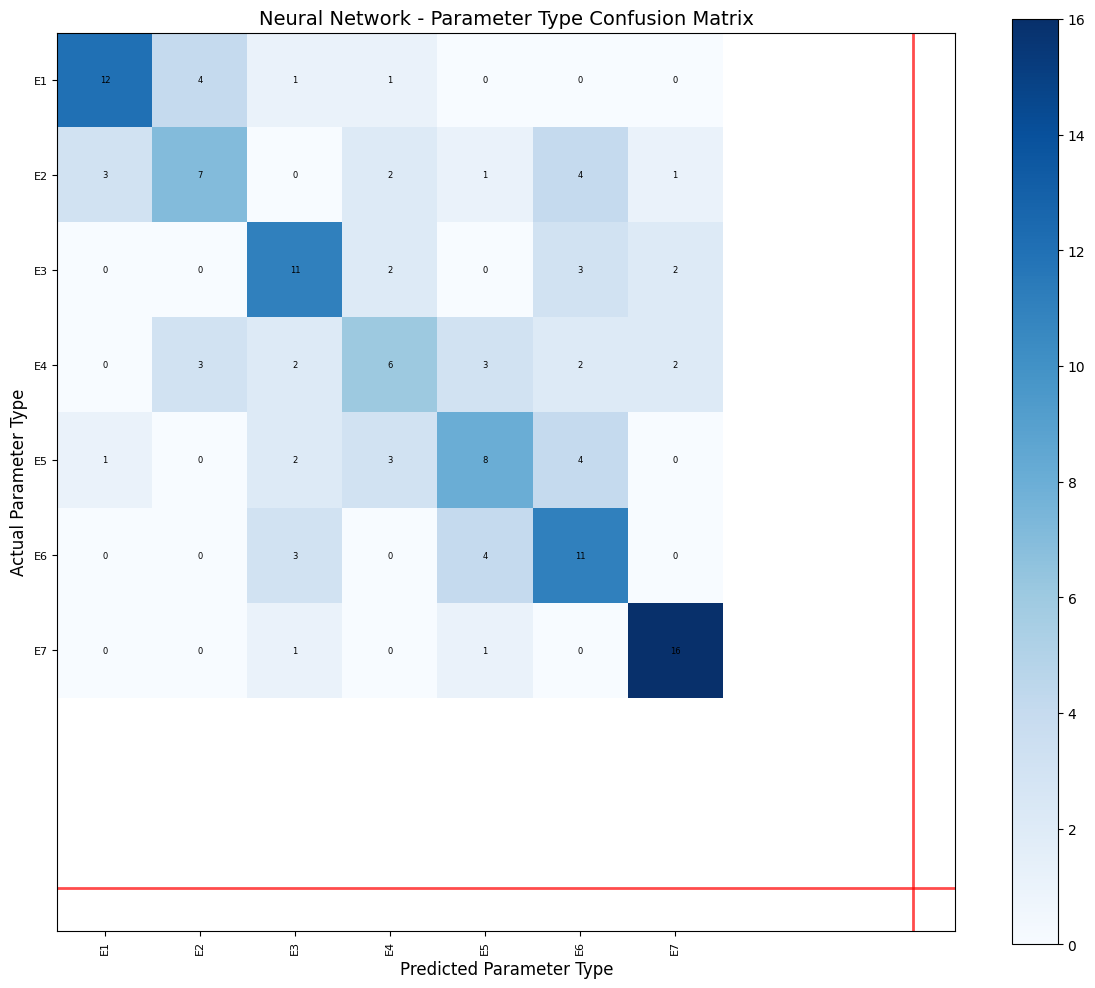

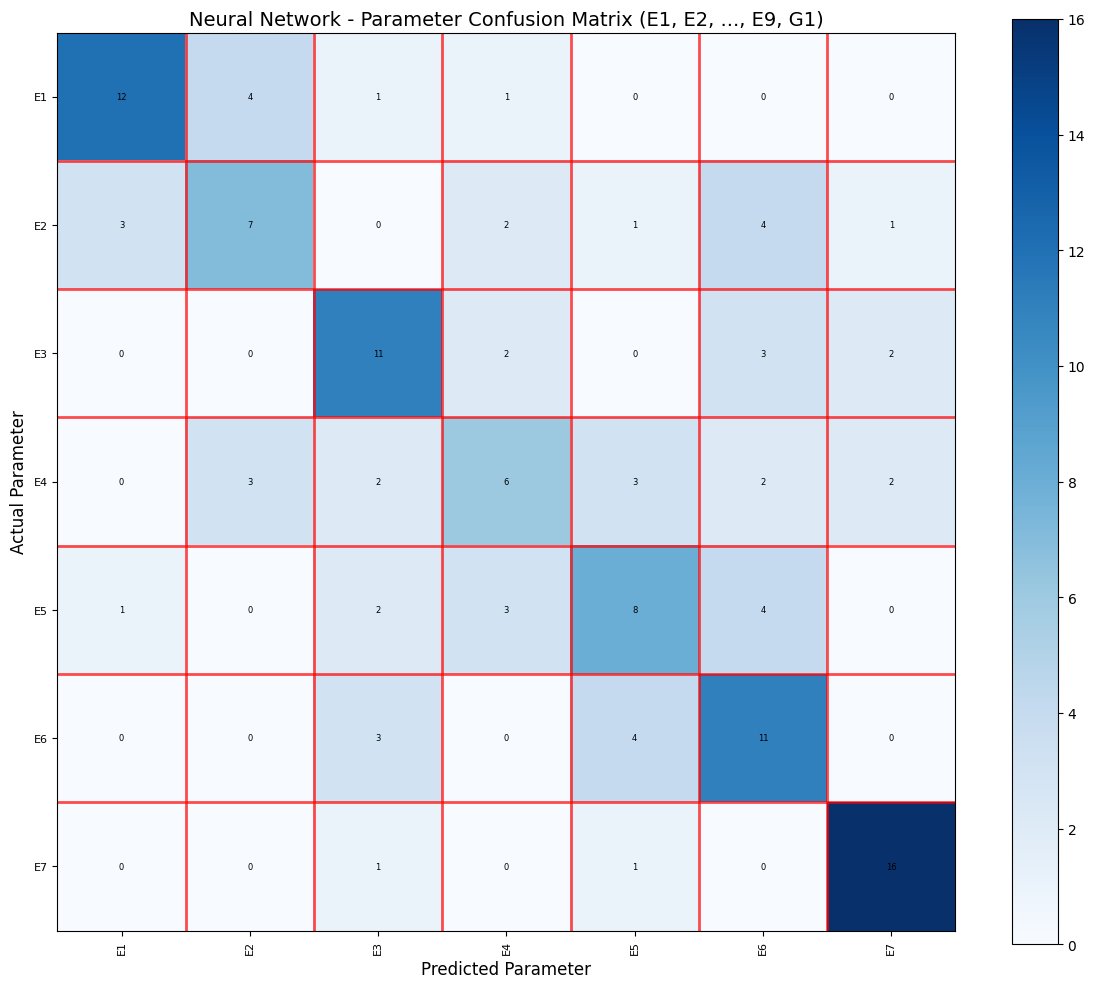

In [111]:
# Plot confusion matrices for both error types and parameter types
print(f"\n" + "="*50)
print("CONFUSION MATRICES")
print("="*50)

# Error Type Confusion Matrix
plt.figure(figsize=(15, 12))
cm_error = confusion_matrix(all_true_error, all_pred_error)

# Create the confusion matrix plot with class names
plt.imshow(cm_error, cmap='Blues', interpolation='nearest')
plt.colorbar()

# Set ticks and labels
plt.xticks(range(len(le_error.classes_)), le_error.classes_, rotation=90, fontsize=8)
plt.yticks(range(len(le_error.classes_)), le_error.classes_, fontsize=8)

plt.title('Neural Network - Error Type Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Error Type', fontsize=12)
plt.ylabel('Actual Error Type', fontsize=12)

# Add text annotations to the confusion matrix
for i in range(len(le_error.classes_)):
    for j in range(len(le_error.classes_)):
        plt.text(j, i, str(cm_error[i, j]), ha='center', va='center', fontsize=6)

plt.tight_layout()
plt.savefig(f"{results_dir}/neural_network_error_confusion_matrix.png", dpi=300, bbox_inches='tight')

# Parameter Type Confusion Matrix
plt.figure(figsize=(12, 10))
cm_parameter = confusion_matrix(all_true_parameter, all_pred_parameter)

# Create the confusion matrix plot with class names
plt.imshow(cm_parameter, cmap='Blues', interpolation='nearest')
plt.colorbar()

# Set ticks and labels
plt.xticks(range(len(le_parameter.classes_)), le_parameter.classes_, rotation=90, fontsize=8)
plt.yticks(range(len(le_parameter.classes_)), le_parameter.classes_, fontsize=8)

plt.title('Neural Network - Parameter Type Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Parameter Type', fontsize=12)
plt.ylabel('Actual Parameter Type', fontsize=12)

# Add text annotations to the confusion matrix
for i in range(len(le_parameter.classes_)):
    for j in range(len(le_parameter.classes_)):
        plt.text(j, i, str(cm_parameter[i, j]), ha='center', va='center', fontsize=6)

# Add red lines to separate different parameter groups (E1-E9, G1)
plt.axvline(x=8.5, color='red', linewidth=2, alpha=0.7)  # After E9, before G1
plt.axhline(y=8.5, color='red', linewidth=2, alpha=0.7)  # After E9, before G1

plt.tight_layout()
plt.savefig(f"{results_dir}/neural_network_parameter_confusion_matrix.png", dpi=300, bbox_inches='tight')

# Create sorted confusion matrix for parameter types (E1, E2, ..., E9, G1)
print(f"\n" + "="*50)
print("NEURAL NETWORK PARAMETER CONFUSION MATRIX - SORTED BY SUFFIX")
print("="*50)

def extract_suffix(name):
    """Extract suffix from parameter name (E1, E2, ..., E9, G1)"""
    return name  # Parameter names are already just the suffix

def get_suffix_order(name):
    """Get numerical order for suffix sorting"""
    if name.startswith('E'):
        try:
            return int(name[1:])  # E1 -> 1, E2 -> 2, etc.
        except:
            return 999  # For any E suffix that's not a number
    elif name == 'G1':
        return 10  # G1 comes after E9
    else:
        return 1000  # Any other suffix

# Sort parameter class names by suffix
sorted_indices = sorted(range(len(le_parameter.classes_)),
                       key=lambda i: get_suffix_order(le_parameter.classes_[i]))
sorted_parameter_names = [le_parameter.classes_[i] for i in sorted_indices]

# Reorder confusion matrix
cm_parameter_sorted = cm_parameter[sorted_indices][:, sorted_indices]

# Create the sorted confusion matrix plot
plt.figure(figsize=(12, 10))
plt.imshow(cm_parameter_sorted, cmap='Blues', interpolation='nearest')
plt.colorbar()

# Set ticks and labels
plt.xticks(range(len(sorted_parameter_names)), sorted_parameter_names, rotation=90, fontsize=8)
plt.yticks(range(len(sorted_parameter_names)), sorted_parameter_names, fontsize=8)

plt.title('Neural Network - Parameter Confusion Matrix (E1, E2, ..., E9, G1)', fontsize=14)
plt.xlabel('Predicted Parameter', fontsize=12)
plt.ylabel('Actual Parameter', fontsize=12)

# Add text annotations to the confusion matrix
for i in range(len(sorted_parameter_names)):
    for j in range(len(sorted_parameter_names)):
        plt.text(j, i, str(cm_parameter_sorted[i, j]), ha='center', va='center', fontsize=6)

# Add red lines to separate different suffixes
current_suffix = None
for i, name in enumerate(sorted_parameter_names):
    suffix = extract_suffix(name)
    if suffix != current_suffix:
        if i > 0:  # Don't add line at the very beginning
            plt.axvline(x=i - 0.5, color='red', linewidth=2, alpha=0.7)
            plt.axhline(y=i - 0.5, color='red', linewidth=2, alpha=0.7)
        current_suffix = suffix

plt.tight_layout()
plt.savefig(f"{results_dir}/neural_network_parameter_confusion_matrix_sorted.png", dpi=300, bbox_inches='tight')


print(f"\nConfusion matrices saved:")
print(f"- Error types: {results_dir}/neural_network_error_confusion_matrix.png")
print(f"- Parameter types: {results_dir}/neural_network_parameter_confusion_matrix.png")
print(f"- Parameter types (sorted): {results_dir}/neural_network_parameter_confusion_matrix_sorted.png")

print(f"\nAll results saved to: {results_dir}")
print(f"Summary report: {results_dir}/training_summary.txt")

In [112]:
import shutil
import os

folder_to_zip = 'eda'
zip_filename = 'eda.zip'

if os.path.exists(folder_to_zip):
    shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', folder_to_zip)
    print(f"Folder '{folder_to_zip}' successfully zipped to '{zip_filename}'")
else:
    print(f"Error: Folder '{folder_to_zip}' not found.")

Folder 'eda' successfully zipped to 'eda.zip'


In [113]:
'''
!rm -r eda
print("The 'eda' folder has been deleted.")
'''

'\n!rm -r eda\nprint("The \'eda\' folder has been deleted.")\n'